<a href="https://colab.research.google.com/github/hseyeon1006/ESAA_YB/blob/main/HW0522.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##04. 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

### LinearRegression 클래스 - Ordinary Least Squares

LinearRegression : 예측값과 실ㅈ값의 RSS를 최소화해 OLS 추정방식으로 구현한 클래스

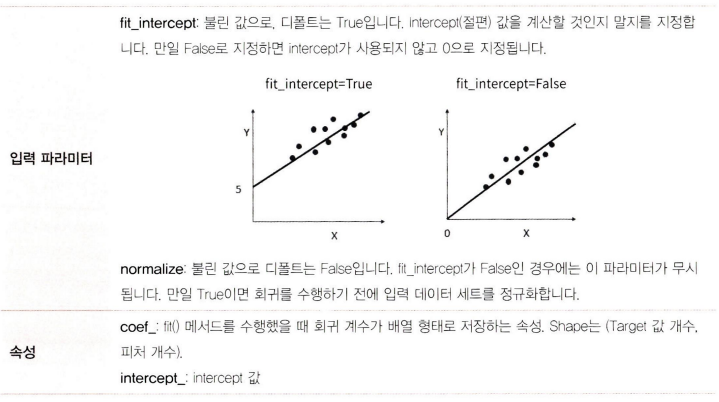

다중공산성 : 피처간의 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 민감해짐

-> 상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제 적용함

###회귀 평가 지표

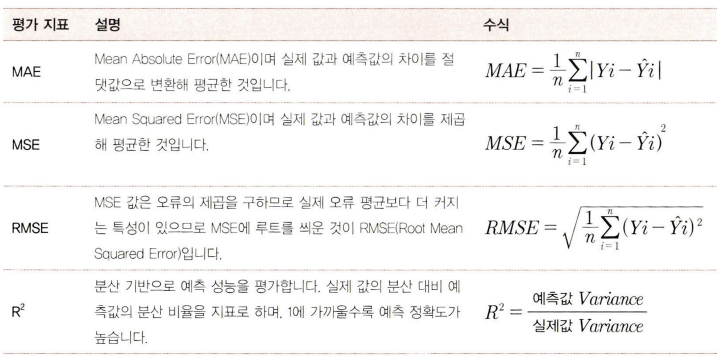

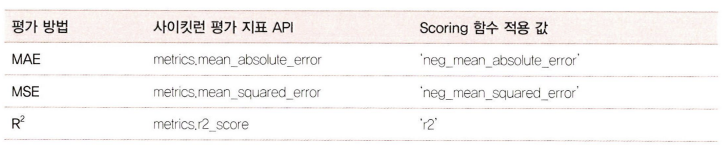

###LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

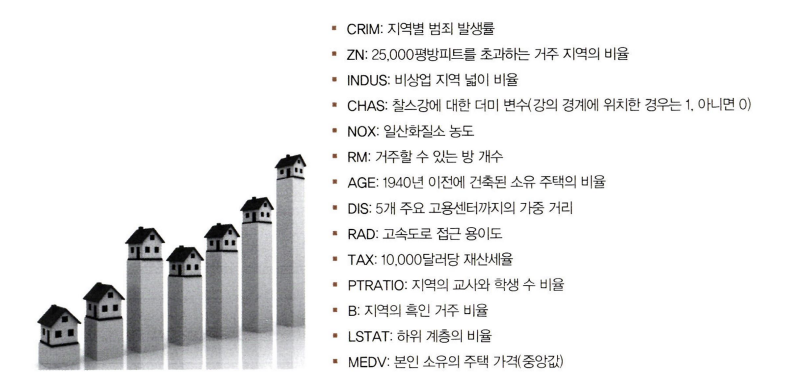

In [1]:
# boston 파일이 sklearn에서 지원되지 않음.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

# feature name이 없으므로 따로 지정해줘야 함.
feature_names=['CRIM',	'ZN',	'INDUS',	'CHAS',	'NOX',	'RM',	'AGE',	'DIS',	'RAD',	'TAX'	,'PTRATIO',	'B'	,'LSTAT',	'PRICE']
bostonDF = pd.DataFrame(boston, columns=feature_names)
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


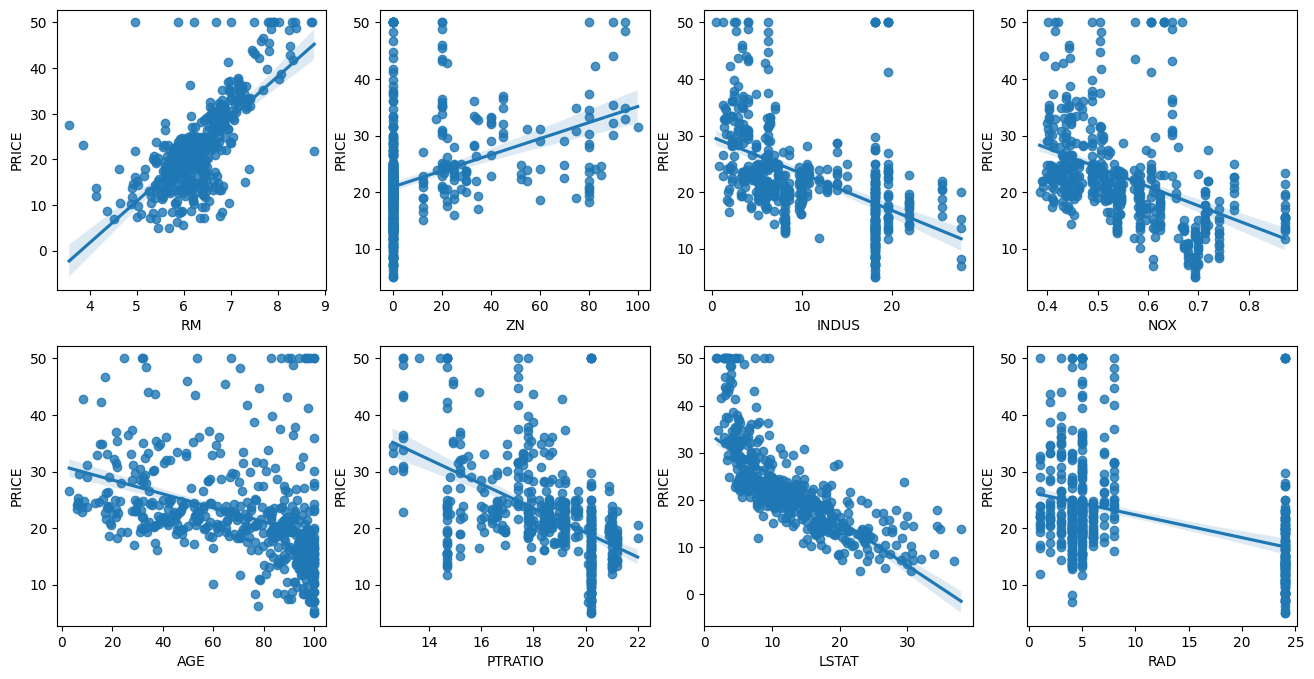

In [2]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
  row = int(i/4)
  col = i%4
  # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현.
  sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

다른 칼럼보다 RM과 LSTAT의 PRICE 영향도가 가장 두드러짐. RM은 양 방향의 선형성이 가장 큼(방의 크기가 클수록 가격이 증가함)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr=LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE:{0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))
print('Variance score: {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE:17.297, RMSE: 4.159
Variance score: 0.757


In [4]:
print('절편 값:', lr.intercept_)
print('회귀 계수 값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164826
회귀 계수 값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [5]:
#회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성
coeff = pd.Series(data=np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending = False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [6]:
from sklearn.model_selection import cross_val_score

y_taret = bostonDF["PRICE"]
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring = 'neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print('5 folds의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores:  [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE: 5.829
